# 导入库

In [36]:
# 不显示warming message
import warnings
warnings.simplefilter('ignore')

In [37]:
# 一些常用的数据处理的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [88]:
# 常见的机器学习库或者深度学习库
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

# 逻辑斯蒂回归模型库
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 决策树模型
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import plot_tree

# 评估库
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score

# 导入数据集

数据集的位置为当前文件夹的父文件夹的 dataset 子文件夹中。

In [39]:
original_data = pd.read_csv('./../dataset/01. conversion_project.csv')

首先产看一下前五行：

In [40]:
original_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


可以发现数据集包含以下的列：

| 字段名称             | 描述                                                                 |
|----------------------|----------------------------------------------------------------------|
| country              | 用户国家，根据IP地址判断                                               |
| age                  | 用户年龄，用户在登录时自报的年龄                                        |
| new_user             | 是否为新用户。新用户指在本次会话中创建账户的用户，非新用户指已有账户的用户 |
| source               | 营销渠道来源                                                          |
|                      | - Ads: 通过点击广告进入网站                                           |
|                      | - Seo: 通过搜索结果点击进入网站                                        |
|                      | - Direct: 直接在浏览器输入网址进入网站                                  |
| total_pages_visited  | 会话期间访问的总页面数，是对在站点上花费时间和参与度的近似值              |
| converted            | 转化标识。1 表示在会话中完成转化，0 表示离开时未购买                    |

公司目标是提高转化率：# 转化次数 / 总会话数。

# 异常值处理

首先查看缺失值情况：

In [41]:
# 检查每一列的缺失值情况
missing_values = original_data.isnull().sum()

# 打印缺失值信息
print(missing_values)

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64


可以发现数据集中并不存在着缺失值。

给出统计行描述的结果：

In [42]:
original_data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


这份描述性统计结果提供了关于一个用户群体的四个变量的统计数据：年龄（age）、是否为新用户（new_user）、访问的总页面数（total_pages_visited）以及转化率（converted）。下面是对这些统计结果的简单描述：

1. **年龄（age）**：
   - 平均年龄是30.57岁，表明这个用户群体相对年轻。
   - 年龄的标准差是8.27岁，说明年龄分布相对分散，从青少年到老年人都有。
   - 最小年龄是17岁，最大年龄是123岁，这个也可能是异常值，因为123这个岁数明显是一个不切实际的年龄
   - 中位数年龄是30岁，说明一半的用户年龄在这个数值以下，另一半在这个数值以上。

2. **新用户（new_user）**：
   - 平均来看，68.55%的用户是新用户，这表明平台有较高的新用户比例。
   - 标准差是0.46，意味着新用户的比例在不同用户之间变化不大。

3. **总页面访问数（total_pages_visited）**：
   - 平均每个用户访问了大约4.87页。
   - 访问页面数的标准差是3.34，说明用户访问页面的数量差异较大。
   - 最少访问1页，最多访问29页，中位数是4页，这表明大多数用户的访问深度较浅。

4. **转化率（converted）**：
   - 平均转化率是3.23%，意味着每100个用户中有大约3个完成了转化。
   - 转化率的标准差是17.67%，这表明转化率在不同用户之间有较大的波动。
   - 最低转化率是0%，最高转化率是100%，中位数是0%，这可能意味着大多数用户没有完成转化。

这里选取age来进行异常值处理：

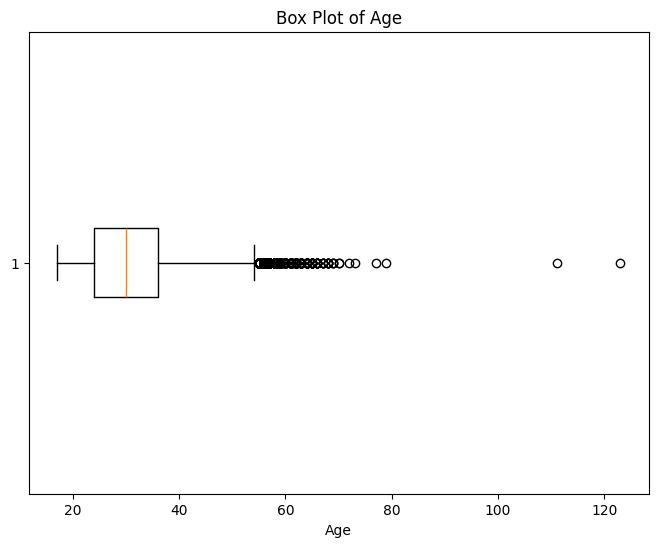

In [43]:
# 绘制 age 列的箱线图来查看异常值
plt.figure(figsize=(8, 6))
plt.boxplot(original_data['age'], vert=False)
plt.title('Box Plot of Age')
plt.xlabel('Age')
plt.show()

可以发现存在着较多的异常值，然后计算出这些异常值并且将其删除：

In [44]:
# 计算IQR (Interquartile Range)
Q1 = original_data['age'].quantile(0.25)
Q3 = original_data['age'].quantile(0.75)
IQR = Q3 - Q1

# 计算异常值的下界和上界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [45]:
# 筛选出异常值数据
outliers = [(original_data['age'] < lower_bound) | (original_data['age'] > upper_bound)]

# 删除异常值数据
data_no_outlier = original_data[(original_data['age'] >= lower_bound) & (original_data['age'] <= upper_bound)]

In [46]:
# 无异常值数据统计性描述
data_no_outlier.describe()

,age,new_user,total_pages_visited,converted
count,314650.000000,314650.000000,314650.000000,314650.000000
mean,30.435954,0.685412,4.873869,0.032385
std,8.064661,0.464352,3.342920,0.177021
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,54.000000,1.000000,29.000000,1.000000


这份新的描述性统计结果同样提供了关于用户群体的四个变量的统计数据，但与之前的结果相比，有一些细微的变化：

1. **年龄（age）**：
   - 平均年龄是30.44岁，与之前的结果相近，仍然表明这个用户群体相对年轻。
   - 年龄的标准差是8.06岁，与之前相比略有减少，说明年龄分布的分散程度略有降低。
   - 最小年龄是17岁，最大年龄是54岁，这表明用户群体的年龄范围有所收窄，老年人的比例可能有所减少。

2. **新用户（new_user）**：
   - 平均来看，68.54%的用户是新用户，这个比例与之前的结果几乎相同，说明平台仍然吸引了相当数量的新用户。

3. **总页面访问数（total_pages_visited）**：
   - 平均每个用户访问了大约4.87页，与之前的结果相同，表明用户的页面访问深度没有显著变化。
   - 访问页面数的标准差是3.34，与之前相同，说明用户访问页面数量的波动仍然较大。

4. **转化率（converted）**：
   - 平均转化率是3.24%，与之前的结果相近，意味着每100个用户中大约有3个完成了转化。
   - 转化率的标准差是17.70%，与之前相比略有增加，这表明转化率的波动可能略有增大。

5. **统计数据的分布情况**：
   - 25%的用户年龄在24岁以下，50%的用户年龄在30岁以下，75%的用户年龄在36岁以下，这表明大多数用户属于年轻到中年的年龄段。
   - 25%的用户至少访问了2页，50%的用户至少访问了4页，75%的用户至少访问了7页，这与之前的结果一致，表明大多数用户的访问深度较浅。

整体来看，这个用户群体依然以年轻人为主，新用户比例高，页面访问深度较浅，转化率相对较低。与之前的结果相比，年龄分布的分散程度略有降低，最大年龄有所减少，但整体用户行为模式没有显著变化。这些统计结果可以为进一步的用户行为分析和市场策略调整提供参考。

# 数据探索 EDA

首先对单个变量的情况进行探索。

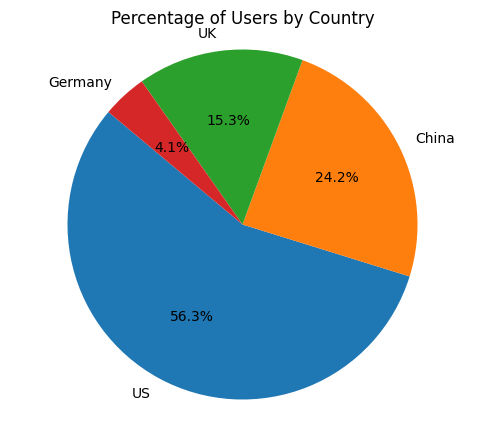

In [47]:
# 计算每个国家的占比
# 计算每个国家的用户数量占比
country_counts = data_no_outlier['country'].value_counts()
country_percentage = country_counts / country_counts.sum() * 100

# 绘制饼状图
plt.figure(figsize=(6, 5))
plt.pie(country_percentage, labels=country_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Users by Country')
plt.axis('equal')  # 确保饼图是圆形的
plt.show()

根据上传的饼状图，该图显示了不同国家用户在数据集中的比例分布。具体如下：

1. **美国 (US)**：占据了大部分，约为56.3%。这表明在数据集中，大多数用户来自美国。
   
2. **中国 (China)**：占24.2%。中国用户占据了第二大的比例。
   
3. **英国 (UK)**：占15.3%。英国用户在数据集中占有中等比例。
   
4. **德国 (Germany)**：占4.1%。德国用户的比例相对较小。

总结：大部分用户来自美国，其次是中国和英国，而来自德国的用户最少。这种分布情况可以帮助我们理解数据集的用户地域分布特征，并有助于为不同国家制定针对性的营销策略。

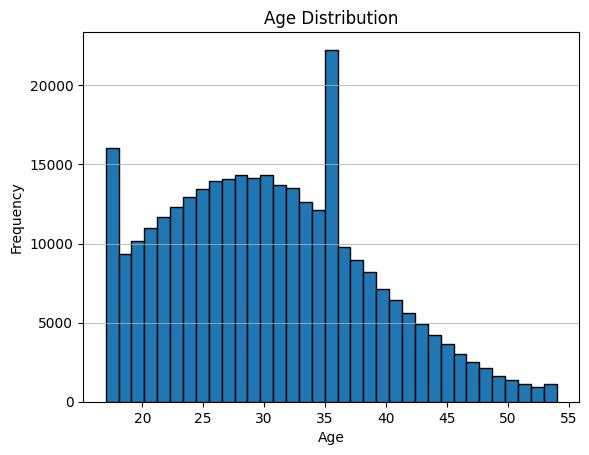

In [48]:
# 使用直方图可视化'age'列的数据
plt.hist(data_no_outlier['age'], bins=35, edgecolor='black')  # bins参数可以根据需要调整
plt.title('Age Distribution')  # 设置图表标题
plt.xlabel('Age')  # 设置x轴标签
plt.ylabel('Frequency')  # 设置y轴标签
plt.grid(axis='y', alpha=0.75)  # 显示y轴网格
plt.show()  # 显示图表

可以发现，年龄变量总体上呈现出了正态分布，或者说有一些轻微的右偏态分布，在17，36这两个年龄段有相对于其他年龄段较高的频率。

接着查看一下new user的情况：

In [49]:
new_user_counts = data_no_outlier['new_user'].value_counts()
new_user_counts

new_user
1    215665
0     98985
Name: count, dtype: int64

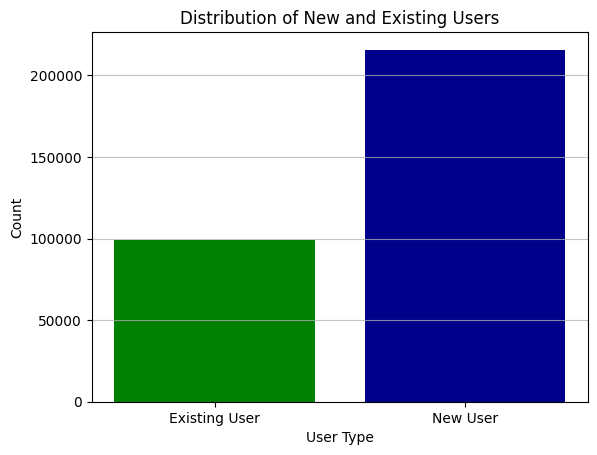

In [50]:
new_user_counts = pd.Series({
    1: 215665,  # 新用户的数量
    0: 98985   # 非新用户的数量
})

# 绘制条形图
plt.bar(new_user_counts.index, new_user_counts.values, color=['darkblue', 'green'])  # 为新用户和非新用户设置不同的颜色

# 设置图表的标题和轴标签
plt.title('Distribution of New and Existing Users')
plt.xlabel('User Type')
plt.ylabel('Count')

# 显示x轴的刻度标签，并设置它们的水平对齐方式
plt.xticks(ticks=new_user_counts.index, labels=['New User', 'Existing User'], rotation=0)

# 显示y轴网格
plt.grid(axis='y', alpha=0.75)

# 显示图表
plt.show()

可以发现，大部分用户都是新用户，新用户的比例是existing user的两倍多一些。

然后来查看一下total page visited的情况：

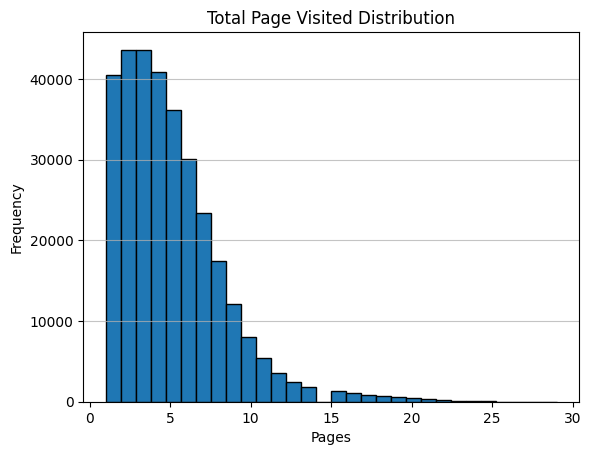

In [51]:
# 使用直方图可视化'total pages visited'列的数据
plt.hist(data_no_outlier['total_pages_visited'], bins=30, edgecolor='black')  # bins参数可以根据需要调整
plt.title('Total Page Visited Distribution')  # 设置图表标题
plt.xlabel('Pages')  # 设置x轴标签
plt.ylabel('Frequency')  # 设置y轴标签
plt.grid(axis='y', alpha=0.75)  # 显示y轴网格
plt.show()  # 显示图表

可以发现该变量呈现出了明显的右偏态分布，绝大部分（大约80%）的用户的流量页数都在0~10之间，并且这部分用户的主要浏览页数在5页以下。

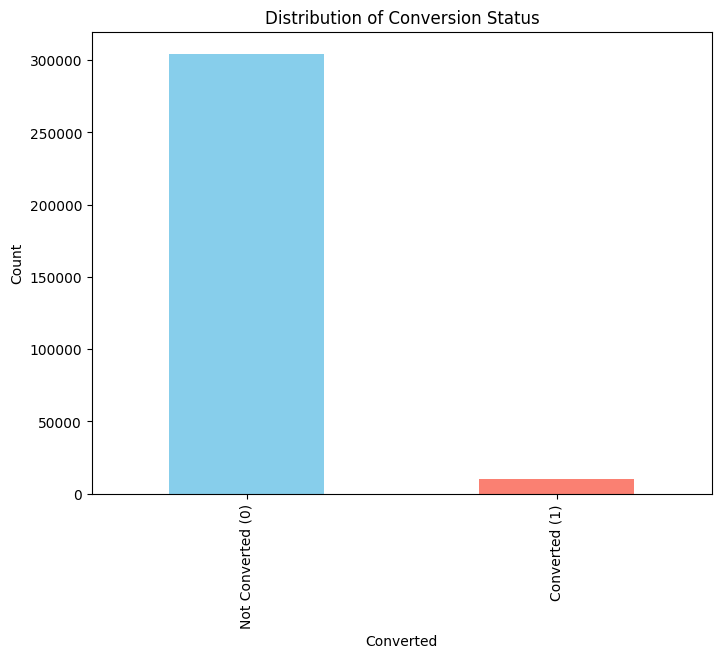

In [52]:
plt.figure(figsize=(8, 6))
data_no_outlier['converted'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Conversion Status')
plt.xlabel('Converted')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Converted (0)', 'Converted (1)'])
plt.show()

从结果来看，可以认为绝大多数的用户都是没有被转换的，转换和被转换之间存在着数十倍的差距。

接着我们可以查看不同特征中的转换率的情况。

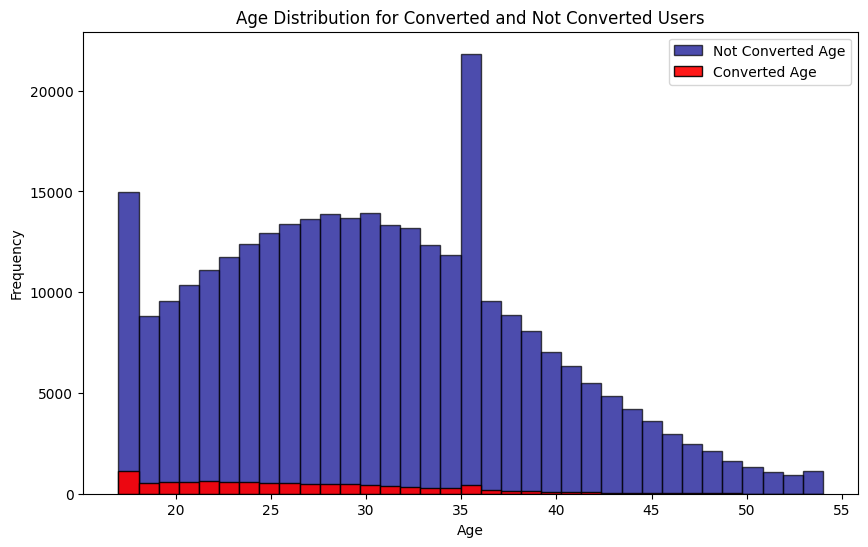

In [53]:
# 绘制转换和未转换用户的年龄分布直方图
plt.figure(figsize=(10, 6))

# 未转换用户的年龄分布直方图
plt.hist(data_no_outlier[data_no_outlier['converted'] == 0]['age'], bins=35, alpha=0.7, label='Not Converted Age', color='darkblue', edgecolor='black')

# 转换用户的年龄分布直方图
plt.hist(data_no_outlier[data_no_outlier['converted'] == 1]['age'], bins=35, alpha=0.9, label='Converted Age', color='red', edgecolor='black')

plt.title('Age Distribution for Converted and Not Converted Users')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

从上图可以发现，完成转换的用户的主要年龄在17~40之间，高于40的情况之下，用户基本不会被转换。

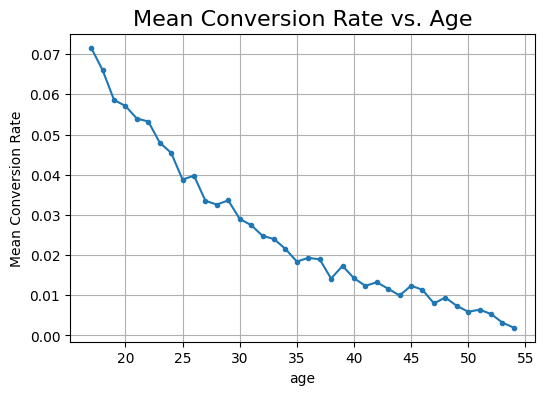

In [54]:
grouped = data_no_outlier[['age', 'converted']].groupby('age').mean().reset_index()
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(grouped['age'], grouped['converted'], '.-')
ax.set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax.set_xlabel('age')
ax.set_ylabel('Mean Conversion Rate')
ax.grid(True)
plt.show()

上述折线图则指出，随着年龄的增长，平均转换率在不断的下降，在45岁之后变低于了0.01。

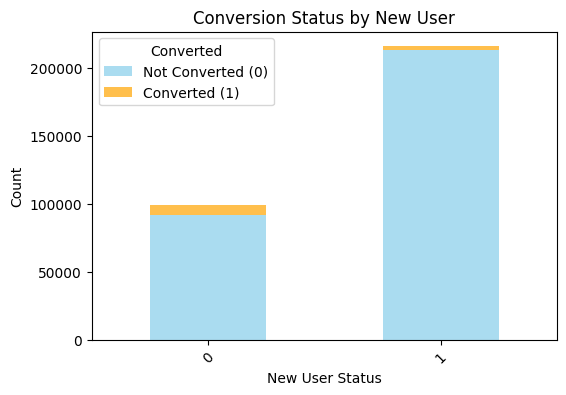

In [55]:
# 计算每个国家和new_user类型中转换和未转换的数量
new_user_counts = data_no_outlier.groupby(['new_user', 'converted']).size().unstack(fill_value=0)

# 绘制分组柱状图
new_user_counts.plot(kind='bar', stacked=True, figsize=(6, 4), color=['skyblue', 'orange'], alpha=0.7)

plt.title('Conversion Status by New User')
plt.xlabel('New User Status')
plt.ylabel('Count')
plt.legend(title='Converted', labels=['Not Converted (0)', 'Converted (1)'])
plt.xticks(rotation=45)
plt.show()

可以发现，无论是回归用户还是回归用户还是新用户，转换用户的总人数都不高，但是从占比的角度来看，Returning User更有可能被转换。

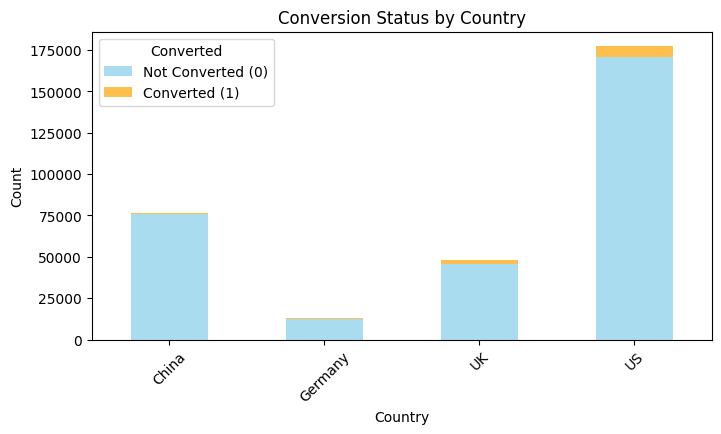

In [56]:
# 计算每个国家和new_user类型中转换和未转换的数量
country_counts = data_no_outlier.groupby(['country', 'converted']).size().unstack(fill_value=0)

# 绘制分组柱状图
country_counts.plot(kind='bar', stacked=True, figsize=(8, 4), color=['skyblue', 'orange'], alpha=0.7)

plt.title('Conversion Status by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Converted', labels=['Not Converted (0)', 'Converted (1)'])
plt.xticks(rotation=45)
plt.show()

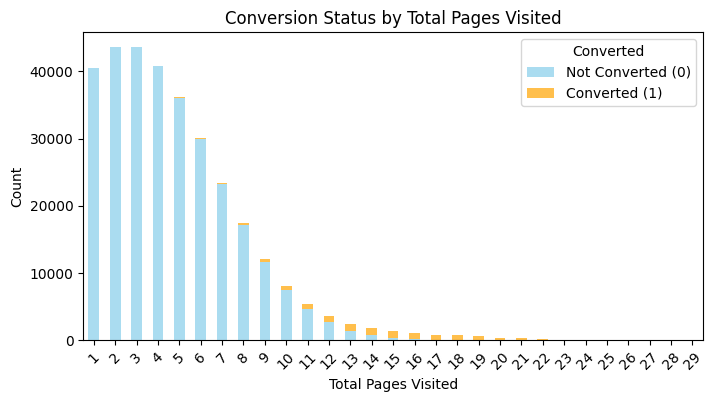

In [57]:
# 计算每个国家和new_user类型中转换和未转换的数量
country_new_user_counts = data_no_outlier.groupby(['total_pages_visited', 'converted']).size().unstack(fill_value=0)

# 绘制分组柱状图
country_new_user_counts.plot(kind='bar', stacked=True, figsize=(8, 4), color=['skyblue', 'orange'], alpha=0.7)

plt.title('Conversion Status by Total Pages Visited')
plt.xlabel('Total Pages Visited')
plt.ylabel('Count')
plt.legend(title='Converted', labels=['Not Converted (0)', 'Converted (1)'])
plt.xticks(rotation=45)
plt.show()

从上图可以发现，总访问页数越多的用户，被转换的数量和占比都会越高，这可能是因为他们感兴趣，才会去访问更多的页面来获取信息。

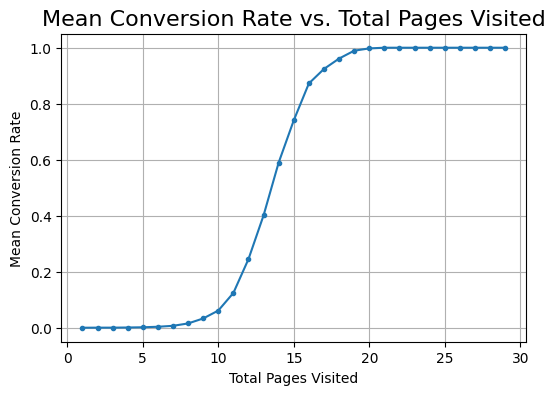

In [58]:
grouped = data_no_outlier[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax.set_title('Mean Conversion Rate vs. Total Pages Visited', fontsize=16)
ax.set_xlabel('Total Pages Visited')
ax.set_ylabel('Mean Conversion Rate')
ax.grid(True)
plt.show()

从上述折线图发现，平均转换率随着总访问页数的增长而不断的增长，在总访问页数达到20页的时候，平均转换率达到了100%。

# 特征工程

接着开始选择重要的特征，用来预测转换。

首先提取数据变量，然后计算相关性。

In [59]:
numeric_data = data_no_outlier[['age', 'total_pages_visited']]

In [60]:
numeric_corr = numeric_data.corr()

In [61]:
numeric_corr

,age,total_pages_visited
age,1.000000,-0.046452
total_pages_visited,-0.046452,1.000000


可以发现这两者之间存在着微乎其微的负相关，因此两个变量都可以保留。

In [62]:
category_data = data_no_outlier[['country', 'new_user', 'source']]

In [63]:
for col in category_data:
    category_data[col] = category_data[col].astype('category')

In [64]:
category_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314650 entries, 0 to 316199
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   country   314650 non-null  category
 1   new_user  314650 non-null  category
 2   source    314650 non-null  category
dtypes: category(3)
memory usage: 3.3 MB


In [65]:
# Step 1: 创建一个函数来计算 Cramér's V
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Step 2: 创建一个空的相关性矩阵
categories = ['country', 'new_user', 'source']
n = len(categories)
cramers_v_matrix = np.zeros((n, n))

# Step 3: 计算每对分类变量的 Cramér's V
for i in range(n):
    for j in range(i, n):
        if i == j:
            cramers_v_matrix[i, j] = 1.0  # 对角线元素设置为1
        else:
            contingency_table = pd.crosstab(data_no_outlier[categories[i]], data_no_outlier[categories[j]])
            cramers_v_matrix[i, j] = cramers_v(contingency_table)
            cramers_v_matrix[j, i] = cramers_v_matrix[i, j]  # 对称矩阵

# 将结果转换为 DataFrame
cramers_v_df = pd.DataFrame(cramers_v_matrix, index=categories, columns=categories)

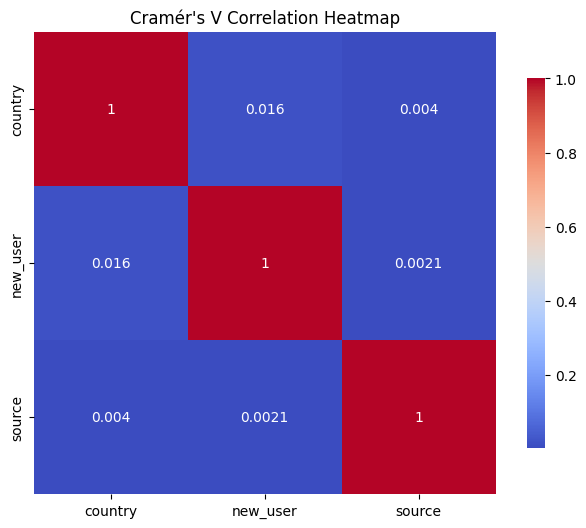

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_df, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title("Cramér's V Correlation Heatmap")
plt.show()

从结果也可以发现，三个分类变量之间也不存在着明显的相关性，所以也保留这三个变量。

In [67]:
# 将特定列转换为类别类型
data_no_outlier['country'] = data_no_outlier['country'].astype('category')
data_no_outlier['new_user'] = data_no_outlier['new_user'].astype('category')
data_no_outlier['source'] = data_no_outlier['source'].astype('category')

In [68]:
# 选择需要进行独热编码的列
categorical_columns = ['country', 'new_user', 'source']

In [69]:
# 进行独热编码
data_no_outlier = pd.get_dummies(data_no_outlier, columns=categorical_columns)

# 查看转换后的DataFrame
print(data_no_outlier.head())

   age  total_pages_visited  converted  country_China  country_Germany  \
0   25                    1          0          False            False   
1   23                    5          0          False            False   
2   28                    4          0          False            False   
3   39                    5          0           True            False   
4   30                    6          0          False            False   

   country_UK  country_US  new_user_0  new_user_1  source_Ads  source_Direct  \
0        True       False       False        True        True          False   
1       False        True       False        True       False          False   
2       False        True       False        True       False          False   
3       False       False       False        True       False          False   
4       False        True       False        True       False          False   

   source_Seo  
0       False  
1        True  
2        True  
3        T

# 模型训练与评估

## 数据集划分

整个数据集被划分为：

1. train data：70%
2. val data：10%
3. test data：20%

In [70]:
# 首先，划分出训练集和剩余部分，训练集占70%
X_train, X_temp, y_train, y_temp = train_test_split(data_no_outlier.drop('converted', axis=1), 
                                                   data_no_outlier['converted'], 
                                                   test_size=0.3, 
                                                   random_state=42)  # random_state确保结果可复现

In [71]:
# 然后，从剩余部分中划分出验证集和测试集，测试集占剩余部分的2/3
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                test_size=0.6667, 
                                                random_state=42)  # 这里的test_size是剩余部分的50%

查看一下：

In [72]:
len(X_train) / len(data_no_outlier), len(X_val) / len(data_no_outlier), len(X_test) / len(data_no_outlier)

(0.7, 0.09998728746225966, 0.20001271253774033)

## 逻辑斯蒂回归模型

In [73]:
# 创建逻辑斯蒂回归模型实例
model = LogisticRegression()

# 训练模型
model.fit(X_train, y_train)

# 预测验证集
y_val_pred = model.predict(X_val)

In [74]:
# 评估模型性能
val_accuracy = accuracy_score(y_val, y_val_pred)
val_classification_report = classification_report(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy}")
print(val_classification_report)

Validation Accuracy: 0.9862687136454659
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     30420
           1       0.87      0.69      0.77      1041

    accuracy                           0.99     31461
   macro avg       0.93      0.84      0.88     31461
weighted avg       0.99      0.99      0.99     31461



模型在验证集上表现出了98.63%的高准确率，这表明在大多数情况下，模型能够正确地进行预测。特别是对于类别0，模型显示出了近乎完美的预测性能，具有99%的精确度和100%的召回率。这意味着当模型预测为类别0时，绝大多数情况下这些预测都是正确的，并且所有实际的类别0样本都被成功识别。

然而，对于类别1，尽管模型的精确度达到了87%，但召回率只有69%，这表明有相当一部分的类别1样本被错误地分类为类别0。这种类别不平衡的现象在数据集中表现为类别0的样本数量远远超过类别1，这可能导致模型对多数类过于敏感，而对少数类的性能不足。

为了解决这个问题，我们可以考虑采取一些措施来处理类别不平衡，例如通过重采样技术来平衡两个类别的样本数量，或者调整分类阈值以提高对少数类的识别能力。此外，使用不同的评估指标，如F1-Score或AUC-ROC曲线，可以提供更全面的模型性能视图。F1-Score作为精确度和召回率的调和平均，为我们提供了一个平衡的视角，其中类别0的F1-Score为99%，而类别1的F1-Score为77%，这进一步突显了模型在两个类别上性能的不平衡。

宏平均和加权平均指标进一步揭示了模型性能的全貌。宏平均指标不考虑类别的支持度，给出了93%的精确度和84%的召回率，而加权平均指标则根据每个类别的样本数量进行了加权，反映出模型在类别0上的高准确率。这些指标表明，尽管模型在多数类上表现优异，但在处理少数类时仍需改进。

最终，为了确保模型的泛化能力，重要的是在独立的测试集上进行类似的评估。这将帮助我们验证模型在未见过的数据上的表现，并确保我们的改进措施在实际应用中同样有效。通过这些分析和改进，我们可以朝着构建一个更加平衡和准确的分类模型迈进。

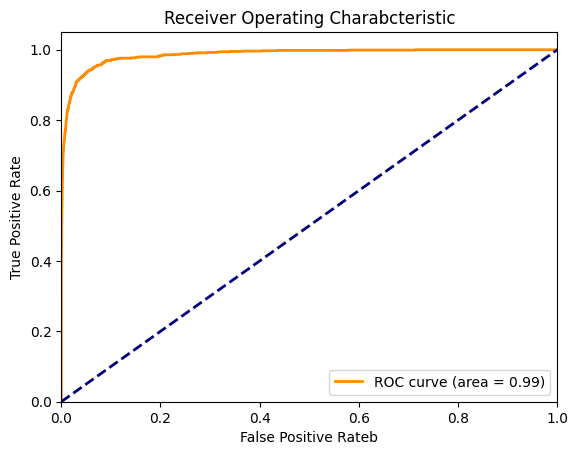

In [75]:
# 获取模型预测的概率
y_val_prob = model.predict_proba(X_val)[:, 1]  # 选择正类的概率

# 计算ROC曲线的FPR和TPR
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rateb')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Charabcteristic')
plt.legend(loc="lower right")
plt.show()

根据ROC曲线图结果，我们可以进行深入的分析。ROC曲线的形状显示了模型在不同假阳性率（FPR）水平上的真阳性率（TPR），而此曲线从左下角（0,0）开始，几乎延伸至右上角（1,1），表明模型在较低的FPR水平上也能保持较高的TPR，这是高分类性能的一个明显标志。

曲线下面积（AUC）为0.99，这是一个非常高的值，接近于完美分类器的性能。AUC衡量了模型在所有可能的分类阈值上的平均性能，高AUC值意味着模型具有出色的区分两个类别的能力。此外，ROC曲线明显位于随机猜测线之上，这条线代表了如果分类完全基于随机选择，模型的性能将会如何。模型的ROC曲线远高于这条线，进一步证实了其有效性。

尽管模型的性能已经非常出色，但根据具体的业务需求，可能还需要进一步优化。例如，如果业务上更重视召回率，即希望尽可能多地识别出正类样本，即使这可能会增加一些假阳性，那么可能需要调整分类阈值以提高模型的召回率。

值得注意的是，ROC曲线和AUC虽然是评估分类模型性能的重要工具，但它们并不是唯一的指标。在实际应用中，还需要考虑模型的解释性、训练时间、预测时间等其他因素。此外，模型在验证集上的性能需要在独立的测试集上进行验证，以确保模型的泛化能力。

综上所述，ROC曲线图结果表明，模型在验证集上表现出色，具有高分类准确性和区分能力。这为模型在实际应用中的有效性提供了强有力的证据。然而，为了确保模型在不同环境和数据集上都能保持高性能，持续的评估和优化是必不可少的。

接着测试在测试集上的性能：

In [76]:
# 预测验证集
y_test_pred = model.predict(X_test)

In [77]:
# 评估模型性能
test_accuracy = accuracy_score(y_test, y_test_pred)
test_classification_report = classification_report(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print(test_classification_report)

Test Accuracy: 0.9859694282899546
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     60851
           1       0.87      0.68      0.76      2083

    accuracy                           0.99     62934
   macro avg       0.93      0.84      0.88     62934
weighted avg       0.99      0.99      0.99     62934



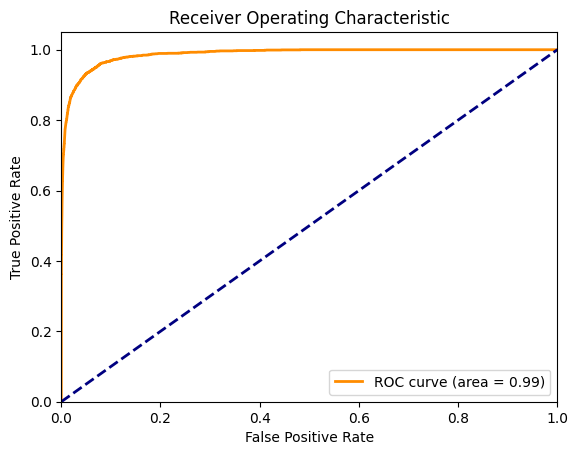

In [78]:
# 获取模型预测的概率
y_test_prob = model.predict_proba(X_test)[:, 1]  # 选择正类的概率

# 计算ROC曲线的FPR和TPR
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

在测试集上，模型展现出了卓越的整体性能，准确率达到了98.59%。这一高准确率表明模型在处理未见过的数据时能够做出非常准确的预测。对于类别0，模型表现出了极高的精确度，达到了99%，意味着几乎所有预测为类别0的样本都是正确的。同时，类别0的召回率更是达到了完美的100%，这表示所有实际的类别0样本都被模型准确识别。

然而，尽管整体性能出色，模型在处理类别1时的性能却有所下降。类别1的精确度为87%，虽然仍然较高，但召回率降低到了68%，这表明有一部分实际为类别1的样本被错误地分类为类别0。这种性能上的不平衡导致了类别1的F1-Score下降到76%，F1-Score是精确度和召回率的调和平均，它揭示了模型在精确度和召回率之间的权衡。

数据集中的类别不平衡是导致这种性能不平衡的一个关键因素。类别0的样本数量远远超过类别1，这可能导致模型对多数类过于敏感，而对少数类的性能不足。从支持度来看，类别0有6万多的样本，而类别1仅有2千多样本，这种不平衡可能会影响模型对少数类的学习能力。

宏平均和加权平均指标进一步揭示了模型在不同类别上的性能。宏平均指标为93%，它将所有类别的指标平均计算，不考虑类别的支持度。而加权平均指标为99%，它根据每个类别的支持度进行加权，因此更倾向于反映多数类的性能。

尽管模型在测试集上显示出了良好的泛化能力，但为了提高对少数类的识别能力，可能需要进一步的调整和优化。可以考虑调整分类阈值来提高召回率，或者采用重采样技术来平衡类别分布。此外，进行特征工程或尝试更复杂的模型也可能是提高少数类识别能力的有效方法。

综上所述，测试集上的结果表明模型具有很高的整体准确率和泛化能力，但在处理少数类时仍有改进空间。通过采取适当的措施来解决类别不平衡问题，可以进一步提升模型的公平性和鲁棒性。

## 决策树模型

首先观察树的深度带来的影响：

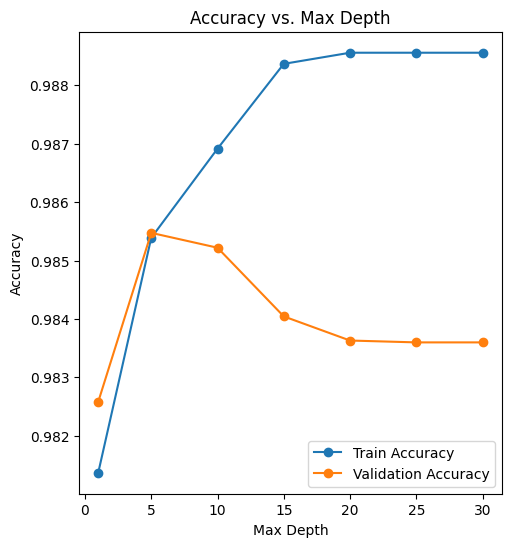

In [89]:
max_depths = [1, 5, 10, 15, 20, 25, 30]  # 修改为你想测试的深度值
train_accuracies = []
val_accuracies = []
train_roc_aucs = []
val_roc_aucs = []

for max_depth in max_depths:
    dtc = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    dtc.fit(X_train, y_train)

    # 在训练集上评估
    y_train_pred = dtc.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_roc_aucs.append(roc_auc_score(y_train, dtc.predict_proba(X_train)[:, 1]))

    # 在验证集上评估
    y_val_pred = dtc.predict(X_val)
    val_accuracies.append(accuracy_score(y_val, y_val_pred))
    val_roc_aucs.append(roc_auc_score(y_val, dtc.predict_proba(X_val)[:, 1]))

# Step 3: 绘制模型性能曲线
plt.figure(figsize=(12, 6))

# 绘制准确性曲线
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(max_depths, val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

从上图可以发现，在树的深度到达了5的时候，validation accuracy开始下降，所以将max depth为5视作是最佳的决策树深度。

接着开始调整min_samples_split这个参数来选择最佳的参数值：

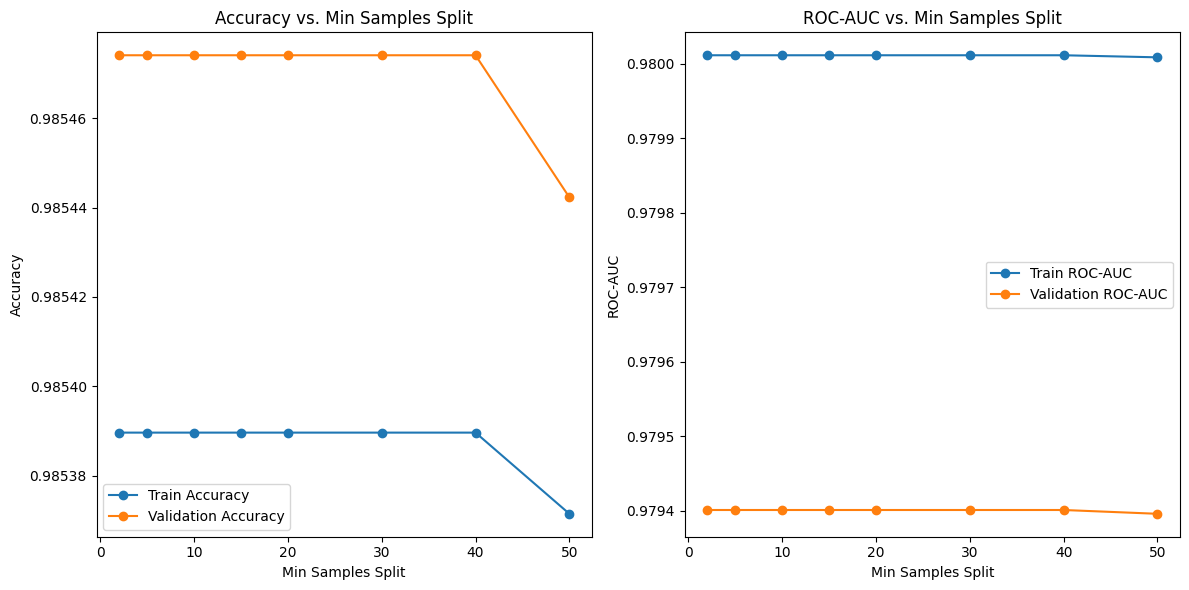

In [91]:
min_samples_splits = [2, 5, 10, 15, 20, 30, 40, 50]  # 可以根据需要调整范围
train_accuracies = []
val_accuracies = []
train_roc_aucs = []
val_roc_aucs = []

for min_samples_split in min_samples_splits:
    dtc = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=min_samples_split)
    dtc.fit(X_train, y_train)

    # 在训练集上评估
    y_train_pred = dtc.predict(X_train)
    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    train_roc_aucs.append(roc_auc_score(y_train, dtc.predict_proba(X_train)[:, 1]))

    # 在验证集上评估
    y_val_pred = dtc.predict(X_val)
    val_accuracies.append(accuracy_score(y_val, y_val_pred))
    val_roc_aucs.append(roc_auc_score(y_val, dtc.predict_proba(X_val)[:, 1]))

plt.figure(figsize=(12, 6))

# 绘制准确性曲线
plt.subplot(1, 2, 1)
plt.plot(min_samples_splits, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(min_samples_splits, val_accuracies, marker='o', label='Validation Accuracy')
plt.title('Accuracy vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend()

# 绘制ROC-AUC曲线
plt.subplot(1, 2, 2)
plt.plot(min_samples_splits, train_roc_aucs, marker='o', label='Train ROC-AUC')
plt.plot(min_samples_splits, val_roc_aucs, marker='o', label='Validation ROC-AUC')
plt.title('ROC-AUC vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('ROC-AUC')
plt.legend()

plt.tight_layout()
plt.show()

可以发现，树的准确性在40之前都是稳定的，所以这里可以将40作为一个选择，因为这可以降低树的复杂性。

In [95]:
best_tree_model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=40)
best_tree_model.fit(X_train, y_train)

y_test_pred = best_tree_model.predict(X_test)
y_test_pred_proba = best_tree_model.predict_proba(X_test)[:, 1]

In [96]:
# 计算准确性
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9845


In [97]:
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Test ROC-AUC: 0.9801


In [98]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[60651   200]
 [  776  1307]]


In [99]:
class_report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     60851
           1       0.87      0.63      0.73      2083

    accuracy                           0.98     62934
   macro avg       0.93      0.81      0.86     62934
weighted avg       0.98      0.98      0.98     62934



根据分类报告和 ROC-AUC 分数，该模型在区分两个类别方面表现良好，尤其是在数据不平衡的情况下。类别 0 的精确度非常高，为 0.99，表明该模型在识别多数类别方面非常出色。但是，类别 1 的精确度为 0.87，召回率较低，为 0.63，这表明该模型在正确识别所有阳性案例方面有些困难。类别 1 的 F1 分数为 0.73，表明该少数类别的精确度和召回率之间取得了合理的平衡。

总体而言，0.98 的准确度可能给人一种高性能的印象，但由于数据不平衡，它不如其他指标那么有用。精确度、召回率和 F1 分数的加权平均值都很高，这进一步证明了该模型通常是有效的。ROC-AUC 分数为 0.9801，进一步表明该模型在类别之间具有很强的判别能力。为了提高模型在少数类上的性能，可以进行进一步的调整，例如使用过采样等技术或调整模型的决策阈值，以更好地平衡第 1 类的准确率和召回率。

# 总结

毫无疑问，这个数据集的目标变量存在着非常严重的不平衡：

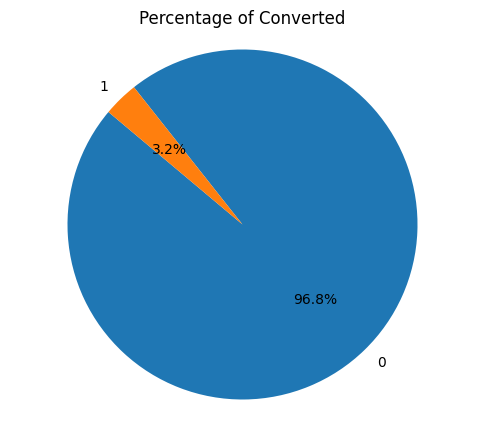

In [101]:
target_counts = data_no_outlier['converted'].value_counts()
target_percentage = target_counts / target_counts.sum() * 100

# 绘制饼状图
plt.figure(figsize=(6, 5))
plt.pie(target_counts, labels=target_percentage.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Converted')
plt.axis('equal')  # 确保饼图是圆形的
plt.show()

约有97%的目标变量都是没有被转换的，只有3%左右的目标变量是被转换了的，所以在接下来的研究中，使用欠采样等采样技术，是非常有必要的。